In [1]:
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [3]:
ds = pd.read_csv('https://raw.githubusercontent.com/LuisSante/Datasets/main/app_reviews.csv')
ds

,package_name,review,date,star
0,com.mantz_it.rfanalyzer,Great app! The new version now works on my Bra...,October 12 2016,4
1,com.mantz_it.rfanalyzer,Great It's not fully optimised and has some is...,August 23 2016,4
2,com.mantz_it.rfanalyzer,Works on a Nexus 6p I'm still messing around w...,August 04 2016,5
3,com.mantz_it.rfanalyzer,The bandwidth seemed to be limited to maximum ...,July 25 2016,3
4,com.mantz_it.rfanalyzer,Works well with my Hackrf Hopefully new update...,July 22 2016,5
...,...,...,...,...
288060,com.termux.api,it doesn't do anything after installing this i...,June 24 2016,3
288061,com.termux.api,I like this app . Its is very helpful for use....,June 20 2016,5
288062,com.termux.api,Finally Brings back the Unix command line to A...,May 20 2016,5
288063,com.termux.api,The API feature is great just need loads more...,May 05 2016,5


In [4]:
list_ = []  
for i in range(len(ds['package_name'].unique())):
    ds_aux = ds.loc[ds['package_name'] == ds['package_name'].unique()[i]]
    #rescatamos en list_ los packages names unicos de todo el dataset
    list_.append({'package_name':ds['package_name'].unique()[i], 'size': len(ds_aux)})

#ordenamos de acuerdo al numero de datos de cada package name (de mayor a menor)
list_ = sorted(list_, key=lambda x: x['size'], reverse=True)

#seleccionamos el package name # 40 y almacenamos los reviews en el corpus
df = ds[ds['package_name'] == list_[40]['package_name']]
corpus = list(df['review'])

corpus_ds = {
    'Sentences' : corpus
}

ds_new = pd.DataFrame(corpus_ds)
print(ds_new)

                                              Sentences
0     Amazing Its great but can someone explain to m...
1     Seems this is one of the best app although I d...
2     Great; needs material design UI. Please use ma...
3                                             Great app
4                                          Cathy Female
...                                                 ...
1090  First time experimenting with this theorpy in ...
1091  Tried and true...no frills without the bells a...
1092                            One of the best so far.
1093              I quit smoking with the self hypnosis
1094   Helps me focus on work with kids running around!

[1095 rows x 1 columns]


In [5]:
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)
corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

In [6]:

def best_cluster_agglomerative(j):
    best_k = 0
    best_average = 0
    for k in range(2,j):

        agglomerative_clusterering = AgglomerativeClustering(n_clusters=k, affinity="cosine" , linkage="complete")
        cluster_labels = agglomerative_clusterering.fit_predict(corpus_embeddings)

        silhouette_avg = silhouette_score(corpus_embeddings, cluster_labels)
    
        if(silhouette_avg > best_average): 
            best_average = silhouette_avg
            best_k = k
            #ds_new['clusters'] = cluster_labels

        #print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)
        #print(cluster_labels)

      ##print("best avg: ", best_average)
      ##print("best k: ", best_k)

    return best_k, best_average

In [7]:
best_k_HC, best_average_HC = best_cluster_agglomerative(10)
print(best_k_HC)

7


In [8]:
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(corpus_embeddings)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

In [9]:
classes = []
for i in range(best_k_HC):
    classes.append('clusters '+ str(i+1))
print(classes)

['clusters 1', 'clusters 2', 'clusters 3', 'clusters 4', 'clusters 5', 'clusters 6', 'clusters 7']


In [10]:
clustering_model = AgglomerativeClustering(n_clusters=best_k_HC, affinity="cosine" , linkage="complete") #, affinity='cosine', linkage='average', distance_threshold=0.4)
clustering_model.fit(X_principal)
cluster_assignment = clustering_model.labels_
ds_new['clusters'] = cluster_assignment
print(cluster_assignment)

[0 3 6 ... 6 0 5]


In [13]:
ds_new = ds_new.sort_values(by=['clusters','Sentences'])
ds_new

,Sentences,clusters,colors
67,-good: Beats organized by purpose: study focu...,0,0.000000
848,A grateful new mom I love the power nap! No ma...,0,0.428571
805,A must have with traveling I travel 40 to 45 w...,0,0.857143
792,ADHD I love love love the ADHD file I really ...,0,0.428571
710,Absolutely love it!! Use quality in-ear phones...,0,0.285714
...,...,...,...
190,its awesome it really does,6,0.714286
109,love it,6,0.428571
844,love it,6,0.857143
1088,no thing to say.... love it!!,6,0.000000


In [14]:
for i in range(10):
    print(i , ds_new['Sentences'][i])

0 Amazing Its great but can someone explain to me how the hipnosis one works?
1 Seems this is one of the best app although I don't know either this is real or not but it's really helpful.. However I've question """"""""""""""""Can i use this using headphone?"""""""""""""""" Reply plz...""
2 Great; needs material design UI. Please use material design for 5 stars!
3 Great app
4 Cathy Female
5 Left me with a BUZZ for an Hour!
6 I use this app and me wake up 7.00 am!!sometime I wake up 11.00am now I use this app I wake up morning
7 Good selection!
8 Notbad I like this app
9 Not good


                                              Sentences  clusters    colors
67    -good: Beats organized by purpose: study  focu...         0  0.000000
848   A grateful new mom I love the power nap! No ma...         0  0.428571
805   A must have with traveling I travel 40 to 45 w...         0  0.857143
792   ADHD I love love love the ADHD file  I really ...         0  0.428571
710   Absolutely love it!! Use quality in-ear phones...         0  0.285714
...                                                 ...       ...       ...
190                         its awesome  it really does         6  0.714286
109                                             love it         6  0.428571
844                                             love it         6  0.857143
1088                      no thing to say.... love it!!         6  0.000000
949                                      works nice job         6  0.714286

[1095 rows x 3 columns]


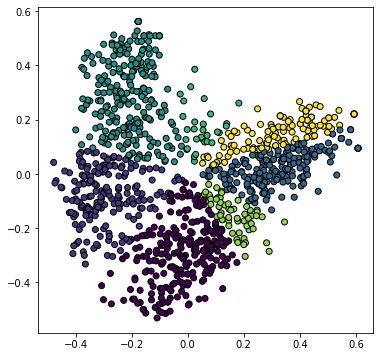

In [12]:
ds_new['colors'] = cluster_assignment.astype(float) / best_k_HC
print(ds_new)
plt.figure(figsize =(6,6))


scatter = plt.scatter(X_principal['P1'], X_principal['P2'], c=ds_new['colors'],edgecolor='k')
plt.show()